In [ ]:
!pip install xgboost openpyxl


In [ ]:
import pandas as pd

# Read the uploaded file
df = pd.read_csv('data.csv', encoding='latin1')

# Quick look at the data
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
#Basic Cleaning and preprocessing
# Drop rows with missing values in key columns
df = df.dropna(subset=['CustomerID', 'InvoiceDate', 'Quantity', 'UnitPrice'])

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate total transaction value
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

# Filter out negative or zero values
df = df[(df['TotalAmount'] > 0) & (df['Quantity'] > 0)]



In [ ]:
#Feature Engineering per Customer
# Set a snapshot date for recency (latest date in data + 1 day)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID and compute features
cltv_df = df.groupby('CustomerID').agg({
    'InvoiceDate': [lambda x: (snapshot_date - x.max()).days,         # Recency
                    lambda x: (x.max() - x.min()).days],              # Tenure
    'InvoiceNo': 'nunique',                                           # Frequency
    'TotalAmount': ['sum', 'mean']                                    # LTV, AOV
}).reset_index()

# Rename columns
cltv_df.columns = ['CustomerID', 'Recency', 'Tenure', 'Frequency', 'LTV', 'AOV']


In [ ]:
#Prepare Data for Modeling
from sklearn.model_selection import train_test_split

# Features and target
X = cltv_df[['Recency', 'Tenure', 'Frequency', 'AOV']]
y = cltv_df['LTV']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
#Train the XGBoost Model
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
#Evaluate the Model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')


MAE: 1870.47
RMSE: 14116.34


In [ ]:
#Predict LTV for All Customers
cltv_df['PredictedLTV'] = model.predict(cltv_df[['Recency', 'Tenure', 'Frequency', 'AOV']])


In [ ]:
#Segment Customers by Predicted LTV
cltv_df['Segment'] = pd.qcut(cltv_df['PredictedLTV'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])


In [ ]:
# Export Results to CSV
cltv_df.to_csv('cltv_predictions.csv', index=False)

# Download the file
from google.colab import files
files.download('cltv_predictions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

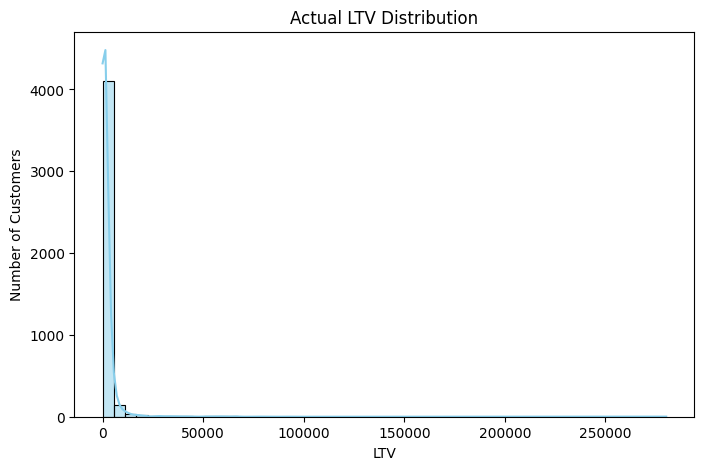

In [ ]:
#LTV Distribution Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(cltv_df['LTV'], bins=50, kde=True, color='skyblue')
plt.title('Actual LTV Distribution')
plt.xlabel('LTV')
plt.ylabel('Number of Customers')
plt.show()

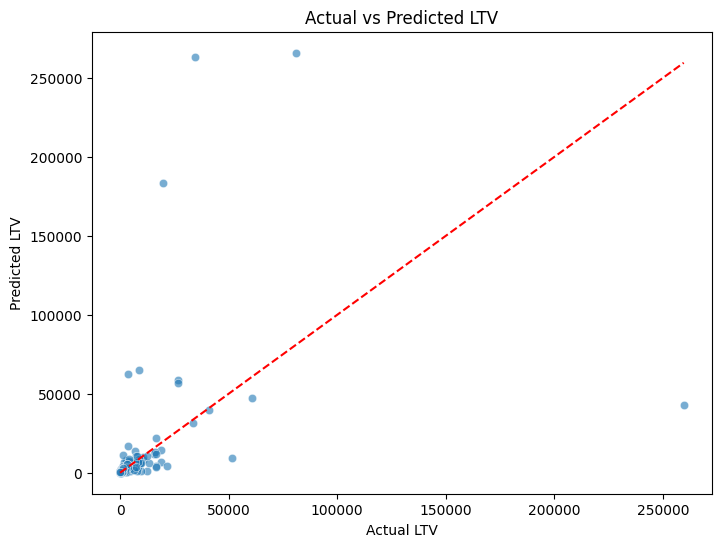

In [12]:
#Predicted vs Actual Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel('Actual LTV')
plt.ylabel('Predicted LTV')
plt.title('Actual vs Predicted LTV')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


/tmp/ipython-input-13-3306560273.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette='Blues_d')


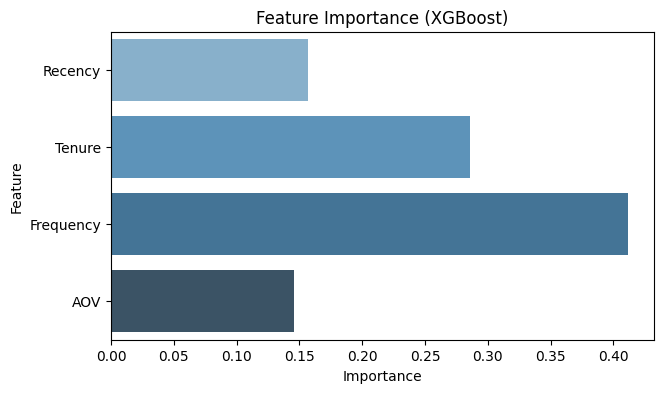

In [13]:
#Feature Importance Plot
importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(7, 4))
sns.barplot(x=importances, y=features, palette='Blues_d')
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


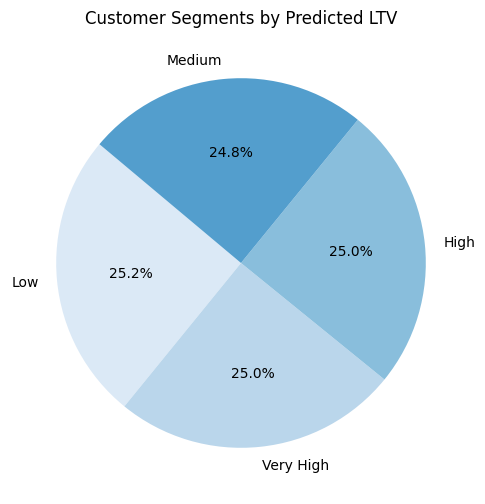

In [14]:
#Segment Size Pie Chart
plt.figure(figsize=(6, 6))
cltv_df['Segment'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Blues'))
plt.title('Customer Segments by Predicted LTV')
plt.ylabel('')
plt.show()
